<a href="https://colab.research.google.com/github/harishkulkarni10/ecommerce-session-recommender/blob/main/notebooks/1_Data_Acquisition_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# STEP 1.0 — Mount Google Drive and verify paths

from google.colab import drive
import os, glob

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Set project root
PROJECT_ROOT = '/content/drive/MyDrive/Data Science course/Major Projects/Projects/e-commerce recommender/diginetica_recommender_project/'

# Subpaths
RAW_PATH       = os.path.join(PROJECT_ROOT, 'data/raw/')
CLEANED_PATH   = os.path.join(PROJECT_ROOT, 'data/cleaned/')
SESSION_PATH   = os.path.join(PROJECT_ROOT, 'data/sessions/')
NOTEBOOKS_PATH = os.path.join(PROJECT_ROOT, 'notebooks/')
MODELS_PATH    = os.path.join(PROJECT_ROOT, 'models/')
RESULTS_PATH   = os.path.join(PROJECT_ROOT, 'results/')

print("Drive mounted successfully!")
print("Project root:", PROJECT_ROOT)
print("\nSubfolders available:")
for p in sorted(glob.glob(PROJECT_ROOT + '*')):
    print("-", os.path.basename(p))


Mounted at /content/drive
Drive mounted successfully!
Project root: /content/drive/MyDrive/Data Science course/Major Projects/Projects/e-commerce recommender/diginetica_recommender_project/

Subfolders available:
- data
- logs
- models
- notebooks
- project_manifest.json
- results
- src
- visuals


In [4]:
# STEP 1.1 — Load a small sample

import pandas as pd
import os

# Path to the main raw file
FILE_PATH = os.path.join(RAW_PATH, 'train-item-views.csv')
print("File path:", FILE_PATH)

# Load first 100k rows
df = pd.read_csv(FILE_PATH, sep=';', nrows=100_000, low_memory=False)
print("Sample loaded successfully — shape:", df.shape)

display(df.head())

# Column names and datatypes
print("\nColumns:")
print(list(df.columns))
print("\nData types:")
print(df.dtypes)

# Missing values overview
print("\nMissing values per column:")
print(df.isna().sum())


File path: /content/drive/MyDrive/Data Science course/Major Projects/Projects/e-commerce recommender/diginetica_recommender_project/data/raw/train-item-views.csv
Sample loaded successfully — shape: (100000, 5)


,sessionId,userId,itemId,timeframe,eventdate
0,1,NaN,81766,526309,2016-05-09
1,1,NaN,31331,1031018,2016-05-09
2,1,NaN,32118,243569,2016-05-09
3,1,NaN,9654,75848,2016-05-09
4,1,NaN,32627,1112408,2016-05-09



Columns:
['sessionId', 'userId', 'itemId', 'timeframe', 'eventdate']

Data types:
sessionId      int64
userId       float64
itemId         int64
timeframe      int64
eventdate     object
dtype: object

Missing values per column:
sessionId        0
userId       55674
itemId           0
timeframe        0
eventdate        0
dtype: int64


### Dropping the `userId` Column — Rationale

The `userId` column in the Diginetica dataset contains **over 55% missing values** and is not essential for our project objective.

This project focuses on **Session-Aware Recommendations**, where the unit of context is the **session**, not the long-term user profile.

- The dataset records **item view sequences within each session** (`sessionId`), but the `userId` is often absent or inconsistent.
- In **session-based recommender systems** like **GRU4Rec**, **SASRec**, or **NextItNet**, models rely on **intra-session behavior** (sequence of items viewed) rather than inter-session history.
- Most published baselines for Diginetica (including the CIKM Cup 2016 competition) **drop `userId`** for this reason.

Hence, we remove the `userId` column to simplify preprocessing and avoid introducing noise or sparsity that does not contribute to model performance.


### Timestamp Cleaning, Sorting, and Basic Standardization

After dropping `userId`, we now prepare the dataset for session-based modeling.

**Goals of this step:**
1. **Ensure chronological order:**  
   Session-based recommenders (like GRU4Rec and SASRec) require item sequences to be ordered by time.
2. **Convert timestamps to datetime objects:**  
   The `eventdate` column currently stores date strings. We convert these into a proper datetime format for consistent sorting and filtering.
3. **Handle data quality issues:**  
   - Remove rows with missing or invalid dates.  
   - Drop duplicate records (same `sessionId`, `itemId`, `eventdate`) to avoid inflating session lengths artificially.
4. **Sort the data:**  
   We sort by `sessionId`, then by `eventdate`, and finally by `timeframe` (which represents intra-session time offset).




In [10]:
# STEP 1.2 - Clean and standardize the data

import numpy as np

df_cleaned = df.copy()

# 1. Drop userId
if 'userId' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['userId'])
    print("Dropped 'userId' column (too many nulls).")

Dropped 'userId' column (too many nulls).


In [12]:
# 2. Convert eventdate to datetime
df_cleaned['eventdate'] = pd.to_datetime(df_cleaned['eventdate'], errors = 'coerce')

In [16]:
# 3. Remove rows with invalid or missing sessions
before = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['sessionId'])
print(f"Removed {before - len(df_cleaned)} rows with invalid/missing dates.")

Removed 0 rows with invalid/missing dates.


In [18]:
# 4. Sort chronologically within sessions
df_cleaned = df_cleaned.sort_values(['sessionId', 'eventdate', 'timeframe']).reset_index(drop=True)
print("Sorted data by sessionId + eventdate + timeframe.")

Sorted data by sessionId + eventdate + timeframe.


In [20]:
# 5. Drop duplicates
before = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates(subset=['sessionId', 'itemId', 'eventdate'])
print(f"Removed {before - len(df_cleaned)} duplicate rows.")

Removed 16629 duplicate rows.


In [21]:
# 6. Final data sanity checks
print('Cleaned dataset shape', df_cleaned.shape)
print(df_cleaned.head())
print("\nRemaining missing values:\n", df_cleaned.isna().sum())

Cleaned dataset shape (83371, 4)
   sessionId  itemId  timeframe  eventdate
0          1    9654      75848 2016-05-09
1          1   33043     173912 2016-05-09
2          1   32118     243569 2016-05-09
3          1   12352     329870 2016-05-09
4          1   35077     390072 2016-05-09

Remaining missing values:
 sessionId    0
itemId       0
timeframe    0
eventdate    0
dtype: int64


### Creating Item Mappings (`item2id` and `id2item`)

Deep learning models require **integer-encoded inputs** rather than raw identifiers.

In our dataset, each `itemId` is a large integer (e.g., 81766, 32627).  
To train models like GRU4Rec or SASRec, we map these to contiguous integer indices:

- `item2id` → maps the original `itemId` to an internal index used by the model  
- `id2item` → inverse mapping to recover the original item IDs from predictions  

These mappings are essential for:
- Building item embedding layers
- Generating recommendations
- Translating model outputs back to actual products


In [22]:
# STEP 1.3 Create item2id and id2item mappings, encode dataset and save cleaned dataset

import pickle

# 1. Mappings
unique_items = df_cleaned['itemId'].unique()
print(f"Found {len(unique_items): ,} unique items")

item2id = {item: idx for idx, item in enumerate(unique_items)}
id2item = {idx: item for item, idx in item2id.items()}

# 2. Encode itemId column
df_encoded = df_cleaned.copy()
df_encoded['item_idx'] = df_encoded['itemId'].map(item2id)

print("\nExample of encoded items")
display(df_encoded.head())

# 3. Save cleaned dataset (encoded version)
cleaned_file_path = os.path.join(CLEANED_PATH, 'cleaned_events.csv')
df_encoded.to_csv(cleaned_file_path, index=False)
print(f"\nSaved cleaned dataset to: {cleaned_file_path}")

# 4. Save mappings for reuse
item2id_path = os.path.join(CLEANED_PATH, 'item2id.pkl')
id2item_path = os.path.join(CLEANED_PATH, 'id2item.pkl')

with open(item2id_path, 'wb') as f:
    pickle.dump(item2id, f)
with open(id2item_path, 'wb') as f:
    pickle.dump(id2item, f)

print(f"Saved item2id to: {item2id_path}")
print(f"Saved id2item to: {id2item_path}")

# 5. Quick check
print("\nCleaned dataset shape:", df_cleaned.shape)
print("Unique items", len(unique_items))
print("Sample mapping: ")
for i, (k, v) in enumerate(list(item2id.items())[:5]):
    print(f"{k} -> {v}")

Found  31,399 unique items

Example of encoded items


<>:22: SyntaxWarning: invalid escape sequence '\S'
<>:22: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-3416183831.py:22: SyntaxWarning: invalid escape sequence '\S'
  print(f"\Saved cleaned dataset to: {cleaned_file_path}")


,sessionId,itemId,timeframe,eventdate,item_idx
0,1,9654,75848,2016-05-09,0
1,1,33043,173912,2016-05-09,1
2,1,32118,243569,2016-05-09,2
3,1,12352,329870,2016-05-09,3
4,1,35077,390072,2016-05-09,4


\Saved cleaned dataset to: /content/drive/MyDrive/Data Science course/Major Projects/Projects/e-commerce recommender/diginetica_recommender_project/data/cleaned/cleaned_events.csv
Saved item2id to: /content/drive/MyDrive/Data Science course/Major Projects/Projects/e-commerce recommender/diginetica_recommender_project/data/cleaned/item2id.pkl
Saved id2item to: /content/drive/MyDrive/Data Science course/Major Projects/Projects/e-commerce recommender/diginetica_recommender_project/data/cleaned/id2item.pkl

Cleaned dataset shape: (83371, 4)
Unique items 31399
Sample mapping: 
9654 -> 0
33043 -> 1
32118 -> 2
12352 -> 3
35077 -> 4


In [ ]:
# 1.4 EDA

### Session Length Distribution

Before modeling, it's important to understand user behavior within sessions.

This plot shows the distribution of session lengths — i.e., how many items users typically view in a single session.

Why it matters:
- Short sessions suggest quick browsing or one-off visits.
- Longer sessions indicate deeper engagement.
- The distribution helps in deciding sequence lengths and padding strategies for sequential models (GRU4Rec, SASRec).


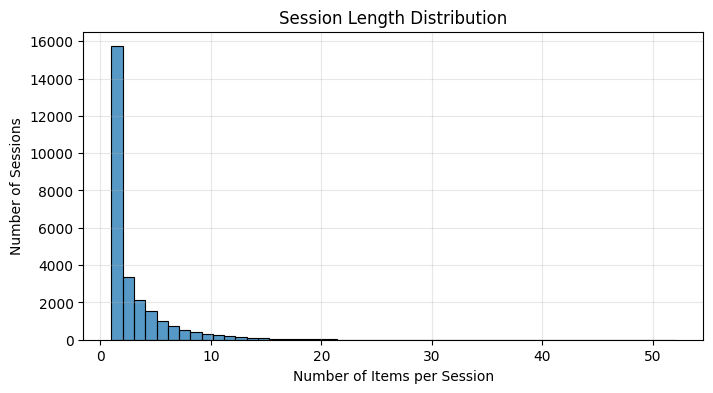

Number of sessions: 26676
Average session length: 3.13
Median session length: 2.0
Max session length: 52


In [23]:
# EDA 1 — Session Length Distribution

import matplotlib.pyplot as plt
import seaborn as sns

# session lengths
session_lengths = df_encoded.groupby('sessionId')['item_idx'].count()

plt.figure(figsize=(8,4))
sns.histplot(session_lengths, bins=50, kde=False)
plt.title('Session Length Distribution')
plt.xlabel('Number of Items per Session')
plt.ylabel('Number of Sessions')
plt.grid(alpha=0.3)
plt.show()

print("Number of sessions:", len(session_lengths))
print("Average session length:", round(session_lengths.mean(), 2))
print("Median session length:", session_lengths.median())
print("Max session length:", session_lengths.max())

### Top-N Popular Items — Item Frequency Distribution

In e-commerce data, item popularity tends to follow a **long-tail distribution**:
- A few items are viewed or purchased very frequently.
- Most items receive little attention.

Understanding this helps us:
- Set realistic baseline models (e.g., popularity-based recommenders).
- Handle data imbalance (many rare items vs. few popular ones).
- Plan model training strategies (e.g., sampling or weighting).

The plot below shows the frequency of the most viewed items in our dataset.


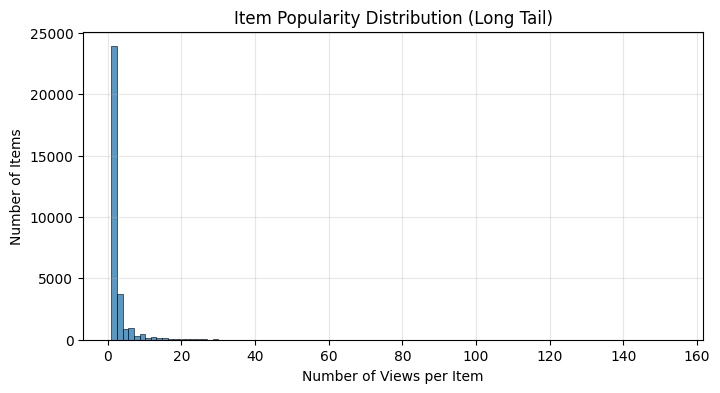

 Total unique items: 31399
 Items with only 1 view: 18832
 Items with > 100 views: 4
 Most popular item viewed: 154 times


In [24]:
# EDA 2 - Item popularity distribution

# item frequency
item_freq = df_encoded['item_idx'].value_counts()

plt.figure(figsize=(8,4))
sns.histplot(item_freq, bins=100, kde=False)
plt.title('Item Popularity Distribution (Long Tail)')
plt.xlabel('Number of Views per Item')
plt.ylabel('Number of Items')
plt.grid(alpha=0.3)
plt.show()

print(" Total unique items:", len(item_freq))
print(" Items with only 1 view:", (item_freq == 1).sum())
print(" Items with > 100 views:", (item_freq > 100).sum())
print(" Most popular item viewed:", item_freq.max(), "times")

### Temporal Interaction Distribution

To understand user activity patterns, we visualize the number of interactions over time.

This helps answer questions like:
- Were there spikes in activity (sales, promotions)?
- Is user engagement steady or seasonal?
- Do we have enough temporal coverage for chronological train/test splits?

Such insights are important for defining realistic validation strategies.


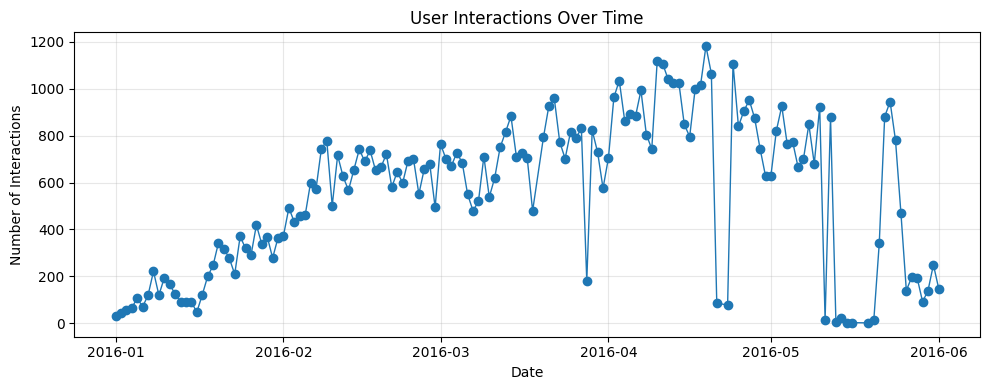

 Date range: 2016-01-01 to 2016-06-01
 Average interactions per day: 559.54
 Lowest daily interactions: 1
 Peak daily interactions: 1182


In [25]:
# EDA 3 - Temporal interaction distribution

# Count interactions by date
interactions_by_date = df_encoded.groupby(df_encoded['eventdate'].dt.date).size()

plt.figure(figsize=(10,4))
interactions_by_date.plot(kind='line', marker='o', linewidth=1)
plt.title('User Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(" Date range:", interactions_by_date.index.min(), "to", interactions_by_date.index.max())
print(" Average interactions per day:", round(interactions_by_date.mean(), 2))
print(" Lowest daily interactions:", interactions_by_date.min())
print(" Peak daily interactions:", interactions_by_date.max())

## Summary of Data Acquisition, Cleaning, and EDA

We completed the first phase of the project — transforming raw Diginetica data into a clean, analysis-ready format.

### Key Achievements
1. **Loaded raw event data** (`train-item-views.csv`) and inspected structure.
2. **Cleaned and standardized**:
   - Dropped sparse `userId` column.
   - Converted `eventdate` to datetime.
   - Sorted chronologically by `sessionId` and `timeframe`.
   - Removed duplicates and invalid timestamps.
3. **Created mappings**:
   - `item2id` / `id2item` for model embedding layers.
   - Saved `cleaned_events.csv` and mappings in `/data/cleaned/`.
4. **Conducted EDA**:
   - **Session lengths:** Avg 3.13 items per session (short browsing behavior).  
   - **Item popularity:** Long-tail distribution — few popular, many rare items.  
   - **Temporal activity:** Steady interactions from Jan → Jun 2016.

### Insights for Modeling
- The dataset is **sparse and short-sessioned**, ideal for **session-based sequence models** (GRU4Rec / SASRec).  
- The **long-tail** nature highlights the importance of embedding-based representations over popularity baselines.  
- **Chronological split** will ensure time-realistic evaluation.

### Outputs Ready for Next Notebook
| File | Description |
|------|--------------|
| `data/cleaned/cleaned_events.csv` | Cleaned, sorted interaction logs |
| `data/cleaned/item2id.pkl` | Mapping: original → encoded item IDs |
| `data/cleaned/id2item.pkl` | Mapping: encoded → original item IDs |

---

Next → **Notebook 2: Session Engineering & Feature Construction**,  
where we’ll create session sequences, engineer basic session features, and split the data into train/val/test chronologically.
